# Attribute Agreement Analysis

Attribute Agreement Analysis is like GAGE R&R but is used for attribute data versus continuous data. Like GAGE, it can confirm if your measurement system is reliable and will identify issues with repeatability (same operator repeating a mea
surement) and reproducibility (different operator measuring the same thing).

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import combinations
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
plt.style.use('classic')

In [19]:
xls = pd.ExcelFile("Six Sigma_Case Study.xlsx")
df = (
    pd.read_excel(xls, 
                   sheet_name="Attribute Agreement",)
        .dropna(how="all")
)
df.columns = df.columns.str.strip()
df.head()

,ID,Appraiser,Response,Sample,Trial,Standard
0,1,John,5,1,1,5
1,2,John,5,1,2,5
2,3,John,3,2,1,3
3,4,John,3,2,2,3
4,5,John,1,3,1,1


In [7]:
df["Appraiser"] = df["Appraiser"].astype(str)
df["Response"]  = df["Response"].astype("category")
df["Standard"]  = df["Standard"].astype("category")

## Step 2:  Within-Appraiser Agreement (repeatability)

In [8]:
within_records = []
for app, g in df.groupby("Appraiser"):
    pivot = g.pivot(index="Sample", columns="Trial", values="Response")
    if set([1,2]).issubset(pivot.columns):
        agree = np.mean(pivot[1] == pivot[2])
        kappa = cohen_kappa_score(pivot[1], pivot[2])
        within_records.append([app, agree, kappa])

within_df = pd.DataFrame(within_records, columns=["Appraiser","Within % Agreement","Within Kappa"])
within_df["Within % Agreement"] = (within_df["Within % Agreement"]*100).round(1)

## Step 3. Between-Appraisers Agreement (reproducibility)

In [9]:
# Use first trial for each appraiser (like Minitab does)
trial1 = df[df["Trial"]==1].pivot(index="Sample", columns="Appraiser", values="Response")

# Percent agreement across all 4 appraisers per sample
between_agree = (trial1.apply(lambda x: len(set(x.dropna()))==1, axis=1)).mean()
# Overall Fleiss’ Kappa
tbl, cats = aggregate_raters(trial1)
between_kappa = fleiss_kappa(tbl)

# Pairwise Cohen’s Kappa (optional detail)
pairwise = []
for (a1,a2) in combinations(trial1.columns,2):
    k = cohen_kappa_score(trial1[a1], trial1[a2])
    pairwise.append([a1,a2,k])
pairwise_df = pd.DataFrame(pairwise, columns=["Appraiser 1","Appraiser 2","Cohen Kappa"])

## Step 4. Appraiser vs Standard (accuracy)

In [10]:
acc_records = []
for app, g in df[df["Trial"]==1].groupby("Appraiser"):
    acc = np.mean(g["Response"]==g["Standard"])
    kappa = cohen_kappa_score(g["Response"], g["Standard"])
    acc_records.append([app, acc, kappa])

acc_df = pd.DataFrame(acc_records, columns=["Appraiser","Accuracy % Agreement","Accuracy Kappa"])
acc_df["Accuracy % Agreement"] = (acc_df["Accuracy % Agreement"]*100).round(1)

## Step 5. Summary Table (Minitab-like)

In [11]:
summary = within_df.merge(acc_df, on="Appraiser", how="outer")
summary = summary[["Appraiser",
                   "Within % Agreement","Within Kappa",
                   "Accuracy % Agreement","Accuracy Kappa"]]
summary.loc[len(summary.index)] = ["All Appraisers Together",
                                   between_agree*100, between_kappa,
                                   np.nan, np.nan]

print("\n=== Attribute Agreement Analysis Summary (Minitab Style) ===")
print(summary.round(3))

print("\nPairwise Between-Appraiser Kappas:")
print(pairwise_df.round(3))


=== Attribute Agreement Analysis Summary (Minitab Style) ===
                 Appraiser  Within % Agreement  Within Kappa  \
0                     John                90.0         0.875   
1                   Leslie                96.0         0.950   
2                   Sheila               100.0         1.000   
3                  Timothy                86.0         0.824   
4  All Appraisers Together                84.0         0.895   

   Accuracy % Agreement  Accuracy Kappa  
0                  94.0           0.925  
1                  96.0           0.950  
2                  94.0           0.925  
3                  90.0           0.874  
4                   NaN             NaN  

Pairwise Between-Appraiser Kappas:
  Appraiser 1 Appraiser 2  Cohen Kappa
0        John      Leslie        0.925
1        John      Sheila        0.950
2        John     Timothy        0.849
3      Leslie      Sheila        0.925
4      Leslie     Timothy        0.874
5      Sheila     Timothy      

## Step 6. Plots (similar to Minitab “Assessment Agreement”)

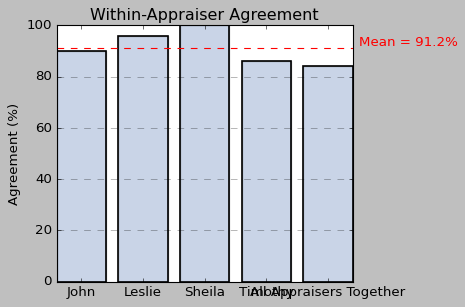

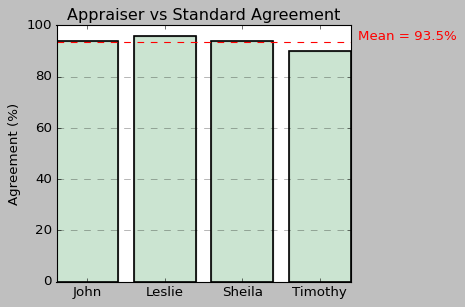

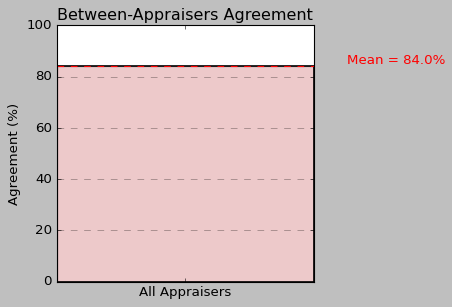

In [15]:
def box_bar_plot(df, value_col, title, color="#4C72B0"):
    fig, ax = plt.subplots(figsize=(6,4))
    bars = ax.bar(df["Appraiser"], df[value_col],
                  edgecolor="black", facecolor=color, alpha=0.3, linewidth=1.2)
    
    # Add box-style outlines (Minitab visual effect)
    for bar in bars:
        x = bar.get_x()
        y = bar.get_height()
        width = bar.get_width()
        rect = mpatches.Rectangle((x, 0), width, y,
                                  fill=False, edgecolor="black", linewidth=1.5)
        ax.add_patch(rect)

    # Add reference line for average
    mean_val = df[value_col].mean()
    ax.axhline(mean_val, color="red", linestyle="--", linewidth=1)
    ax.text(len(df)-0.5, mean_val+1, f"Mean = {mean_val:.1f}%", color="red")

    ax.set_ylim(0, 100)
    ax.set_ylabel("Agreement (%)")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Plot: Within-Appraiser Agreement ---
box_bar_plot(summary.dropna(subset=["Within % Agreement"]),
             "Within % Agreement",
             "Within-Appraiser Agreement", color="#4C72B0")

# --- Plot: Appraiser vs Standard ---
box_bar_plot(summary.dropna(subset=["Accuracy % Agreement"]),
             "Accuracy % Agreement",
             "Appraiser vs Standard Agreement", color="#55A868")

# --- Plot: Between-Appraisers Agreement ---
between_df = pd.DataFrame({
    "Appraiser": ["All Appraisers"],
    "Between % Agreement": [between_agree*100]
})
box_bar_plot(between_df, "Between % Agreement",
             "Between-Appraisers Agreement", color="#C44E52")

## Summary

### Practical considerations
- Illustration
  - In this case, the results showed the test method is adequate for a standard kappa at 0.7.
  - However, the percent accuracy (and CI) is lower than we would prefer for a life-critical 
system.
  - Further review by the team revealed the pinhole test was the least accurate.
  - Given some bags passed the test (and were installed in cars but failed later in an 
accident), a new test was designed and shown to be 98% reliable to predict pinhole 
failures.